In [1]:
# this clones the PGM repository in the ../PGM folder if it does not exists
# please modify this line as needed if you want to have the PMG repository elsewhere
import os, sys
pgm_path = '../PGM/'
if not os.path.isdir(out_path): # check if folder exists
    from git import Repo
    Repo.clone_from("https://github.com/jertubiana/PGM.git", pgm_path)
sys.path.append('../PGM/source/')
sys.path.append('../PGM/utilities/')
sys.path.append('../DNA_utils/')

In [2]:
# imports
from common_imports import set_num_threads
set_num_threads(2) # Set the number of cores. Must be executed before importing numpy&numba.
import rbm, RBM_utils
import DNA_utils, DNA_sequence_logo, DNA_plots_utils

import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

C:/Users/digioacchino/data_work/repos/PGM/source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
C:/Users/digioacchino/data_work/repos/PGM/source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights


In [3]:
# load data
path = '../data/'
filename = 's100_6th.fasta'
all_data_6, counts_6 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)
n_tot_6 = all_data_6.shape[0]
seq_len_6 = all_data_6.shape[1]
print('Dataset #6 shape =', all_data_6.shape)

filename = 's100_8th.fasta'
all_data_8, counts_8 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)
n_tot_8 = all_data_8.shape[0]
seq_len_8 = all_data_8.shape[1]
print('Dataset #8 shape =', all_data_8.shape)

Dataset #6 shape = (735974, 40)
Dataset #8 shape = (719413, 40)


In [4]:
# split left and right data
seqs_8_l_2num, counts_8_l = np.unique(all_data_8[:, :20], return_counts=True, axis=0)
all_data_8_l = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_8_l_2num),
                             'counts' : counts_8_l})
all_data_8_l['seq2num'] = list(DNA_utils.seq2num(all_data_8_l['sequence'].to_list()))
n_tot_8_l = len(all_data_8_l.sequence)
all_seq_8_l = np.array(all_data_8_l['seq2num'].to_list())
counts_8_l = all_data_8_l['counts'].to_numpy()
print('Dataset #8 shape =', all_data_8_l.shape)

# load round 8 right data 
seqs_8_r_2num, counts_8_r = np.unique(all_data_8[:, 20:], return_counts=True, axis=0)
all_data_8_r = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_8_r_2num),
                             'counts' : counts_8_r})
all_data_8_r = all_data_8_r.sort_values(by="counts", ascending=False).reset_index(drop=True)
all_data_8_r['seq2num'] = list(DNA_utils.seq2num(all_data_8_r['sequence'].to_list()))
n_tot_8_r = len(all_data_8_r.sequence)
all_seq_8_r = np.array(all_data_8_r['seq2num'].to_list())
counts_8_r = all_data_8_r['counts'].to_numpy()
print('Dataset #8 shape =', all_data_8_r.shape)
all_data_8_r.sort_values(by="counts", ascending=False)

# put both rounds together
all_data_8_lr = pd.concat([all_data_8_l, all_data_8_r])
all_data_8_lr = all_data_8_lr.reset_index(drop=True)
all_data_8_lr = all_data_8_lr.drop(columns=['seq2num']) # drop this, gives problems with groupby...
all_data_8_lr = all_data_8_lr.groupby(by=["sequence"], as_index=False).sum()
all_data_8_lr = all_data_8_lr.sort_values(by='counts', ascending=False).reset_index(drop=True)
all_seq_8_lr = DNA_utils.seq2num(all_data_8_lr["sequence"].to_list())
counts_8_lr = all_data_8_lr['counts'].to_numpy()

Dataset #8 shape = (196682, 3)
Dataset #8 shape = (253098, 3)


# RBM-D6 re-training

In [5]:
# prepare training and test set
permutation = np.random.permutation(n_tot_6)
rbm_d6_dataset = all_data_6[permutation]
test_len = rbm_d6_dataset.shape[0] // 10
train_data = rbm_d6_dataset[test_len:]
test_data = rbm_d6_dataset[:test_len]

In [6]:
# training
n_v = train_data.shape[1] # Number of visible units; = # sites in alignment.
n_h = 90
nmc = 10 # Number of Monte Carlo steps between each update.
lib = 1e-2 # L1b regularization. Default : 0.
visible = 'Potts' # Nature of visible units potential. Here, Potts states.
n_cv = 4
hidden = 'dReLU' # Nature of hidden units potential. Here, dReLU potential.
train_len = train_data.shape[0]
test_len = test_data.shape[0]
RBM_D6 = rbm.RBM(visible = visible,hidden = hidden, n_v = n_v, n_h = n_h, n_cv = n_cv)
batch_size = 500 # Size of mini-batches (and number of Markov chains used).
n_updates = int(2e4)
n_iter = (n_updates // (train_data.shape[0] // batch_size))
print('Using ', n_iter, ' epochs.')

RBM_D6.fit(train_data, batch_size = batch_size, n_iter = n_iter, l1b = lib, N_MC = nmc, verbose = 0, vverbose = 1)

Using  15  epochs.
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15


{}

''

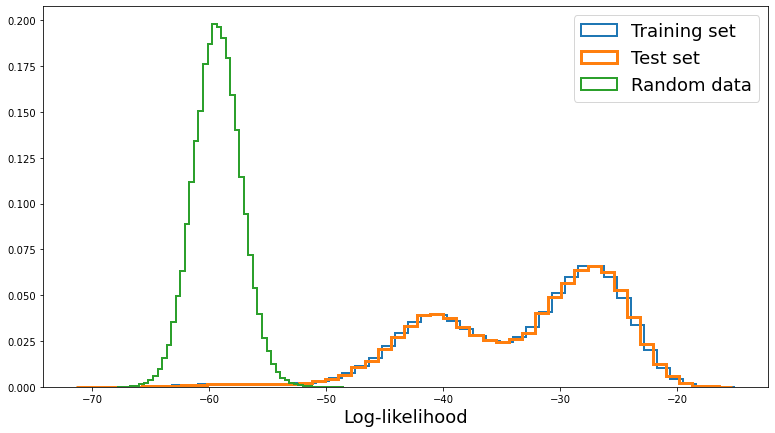

In [10]:
# check results on test set and on a set of random sequences
rand_data = np.random.randint(low=0, high=3, size=test_data.shape, dtype=np.int16)

fig = plt.figure(figsize=(13, 7), constrained_layout=False)
ax = fig.add_subplot()
ax.hist(RBM_D6.likelihood(train_data), bins=50, density=True, histtype='step', lw=2, fill=False, label="Training set")
ax.hist(RBM_D6.likelihood(test_data), bins=50, density=True, histtype='step', lw=3, fill=False, label="Test set")
ax.hist(RBM_D6.likelihood(rand_data), bins=50, density=True, histtype='step', lw=2, fill=False, label="Random data")

ax.legend(fontsize=18, loc=1)
ax.set_xlabel("Log-likelihood", fontsize=18)
;

In [11]:
# save RBM
out_path = '../RBM_retrained/'
if not os.path.isdir(out_path): # check if folder exists
    os.makedirs(out_path)
    
file_name = 'RBM_D6.data'
RBM_utils.saveRBM(out_path + file_name, RBM_D6)

# RBM-D8 re-training

In [12]:
# prepare training and test set
permutation = np.random.permutation(n_tot_8)
rbm_d8_dataset = all_data_8[permutation]
test_len = rbm_d8_dataset.shape[0] // 10
train_data = rbm_d8_dataset[test_len:]
test_data = rbm_d8_dataset[:test_len]

In [13]:
# training
n_v = train_data.shape[1]
n_h = 120
nmc = 2
lib = 1e-2
visible = 'Potts'
n_cv = 4
hidden = 'dReLU'
train_len = train_data.shape[0]
test_len = test_data.shape[0]
RBM_D8 = rbm.RBM(visible = visible,hidden = hidden, n_v = n_v, n_h = n_h, n_cv = n_cv)
batch_size = 800
n_updates = int(2e4)
n_iter = (n_updates // (train_data.shape[0] // batch_size))
print('Using ', n_iter, ' epochs.')

RBM_D8.fit(train_data, batch_size = batch_size, n_iter = n_iter, l1b = lib, N_MC = nmc, verbose = 0, vverbose = 1)

Using  24  epochs.
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24


{}

''

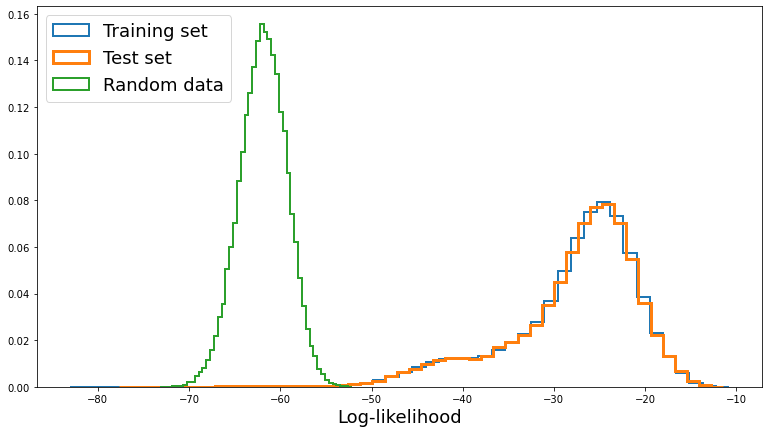

In [15]:
# check results on test set and on a set of random sequences
rand_data = np.random.randint(low=0, high=3, size=test_data.shape, dtype=np.int16)

fig = plt.figure(figsize=(13, 7), constrained_layout=False)
ax = fig.add_subplot()
ax.hist(RBM_D8.likelihood(train_data), bins=50, density=True, histtype='step', lw=2, fill=False, label="Training set")
ax.hist(RBM_D8.likelihood(test_data), bins=50, density=True, histtype='step', lw=3, fill=False, label="Test set")
ax.hist(RBM_D8.likelihood(rand_data), bins=50, density=True, histtype='step', lw=2, fill=False, label="Random data")

ax.legend(fontsize=18, loc=2)
ax.set_xlabel("Log-likelihood", fontsize=18)
;

In [16]:
# save RBM
out_path = '../RBM_retrained/'
if not os.path.isdir(out_path): # check if folder exists
    os.makedirs(out_path)
    
file_name = 'RBM_D8.data'
RBM_utils.saveRBM(out_path + file_name, RBM_D8)

# RBM-S re-training

In [17]:
# prepare training and test set
n_tot_8_lr = len(all_data_8_lr.sequence)
permutation = np.random.permutation(n_tot_8_lr)
rbm_s_dataset = all_seq_8_lr[permutation]
test_len = rbm_s_dataset.shape[0] // 10
train_data = rbm_s_dataset[test_len:]
test_data = rbm_s_dataset[:test_len]

In [18]:
# training
n_v = train_data.shape[1]
n_h = 70
nmc = 4
lib = 1e-2
visible = 'Potts'
n_cv = 4
hidden = 'dReLU'
train_len = train_data.shape[0]
test_len = test_data.shape[0]
RBM_S = rbm.RBM(visible = visible, hidden = hidden, n_v = n_v, n_h = n_h, n_cv = n_cv)
batch_size = 500
n_updates = int(2e4)
n_iter = (n_updates // (train_data.shape[0] // batch_size))
print('Using ', n_iter, ' epochs.')

RBM_S.fit(train_data, batch_size = batch_size, n_iter = n_iter, l1b = lib, N_MC = nmc, verbose = 0, vverbose = 1)

Using  29  epochs.
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29


{}

Mismatch dimensions (500, 70), [10, 70], reinitializating I
Mismatch dimensions (500, 20, 4), [10, 20, 4], reinitializating I


''

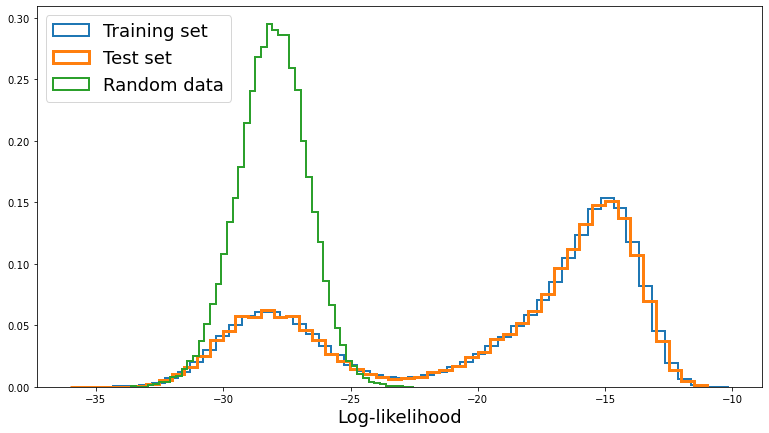

In [19]:
# check results on test set and on a set of random sequences
rand_data = np.random.randint(low=0, high=3, size=test_data.shape, dtype=np.int16)

fig = plt.figure(figsize=(13, 7), constrained_layout=False)
ax = fig.add_subplot()
ax.hist(RBM_S.likelihood(train_data), bins=50, density=True, histtype='step', lw=2, fill=False, label="Training set")
ax.hist(RBM_S.likelihood(test_data), bins=50, density=True, histtype='step', lw=3, fill=False, label="Test set")
ax.hist(RBM_S.likelihood(rand_data), bins=50, density=True, histtype='step', lw=2, fill=False, label="Random data")

ax.legend(fontsize=18, loc=2)
ax.set_xlabel("Log-likelihood", fontsize=18)
;

In [20]:
# save RBM
out_path = '../RBM_retrained/'
if not os.path.isdir(out_path): # check if folder exists
    os.makedirs(out_path)
    
file_name = 'RBM_S.data'
RBM_utils.saveRBM(out_path + file_name, RBM_S)

# RBM-SC re-training

In [23]:
# create dataset through resampling (using tower sampling)
dataset_size = 725431 # same size of the full (40 nts) dataset
# i) compute probability of each sequence
probs = counts_8_lr
seqs = all_seq_8_lr
# ii) now divide the interval (0,1) in parts of the right lenght
tot_probs = np.sum(probs)
probs2 = np.array(probs/tot_probs, dtype = np.float64)
tower = np.zeros(len(probs2), dtype = np.float64)
t = 0
for i, pr in enumerate(probs2):
    t = t + pr
    tower[i] = t
# now sample
resampled_seq2num = []
for i in range(dataset_size):
    x = random.random()
    idx = tower.searchsorted(x)
    resampled_seq2num.append(seqs[idx])
resampled_seq2num = np.array(resampled_seq2num)

In [24]:
# prepare training and test set
test_len = resampled_seq2num.shape[0] // 10
train_data = resampled_seq2num[test_len:]
test_data = resampled_seq2num[:test_len]

In [25]:
# training
n_v = train_data.shape[1]
n_h = 80
nmc = 2
lib = 1e-2
visible = 'Potts'
n_cv = 4
hidden = 'dReLU'
train_len = train_data.shape[0]
test_len = test_data.shape[0]
RBM_SC = rbm.RBM(visible = visible,hidden = hidden, n_v = n_v, n_h = n_h, n_cv = n_cv)
batch_size = 1000
n_updates = int(2e4)
n_iter = (n_updates // (train_data.shape[0] // batch_size))
print('Using ', n_iter, ' epochs.')

RBM_SC.fit(train_data, batch_size = batch_size, n_iter = n_iter, l1b = lib, N_MC = nmc, verbose = 0, vverbose = 1)

Using  30  epochs.
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30


{}

Mismatch dimensions (1000, 80), [10, 80], reinitializating I
Mismatch dimensions (1000, 20, 4), [10, 20, 4], reinitializating I


''

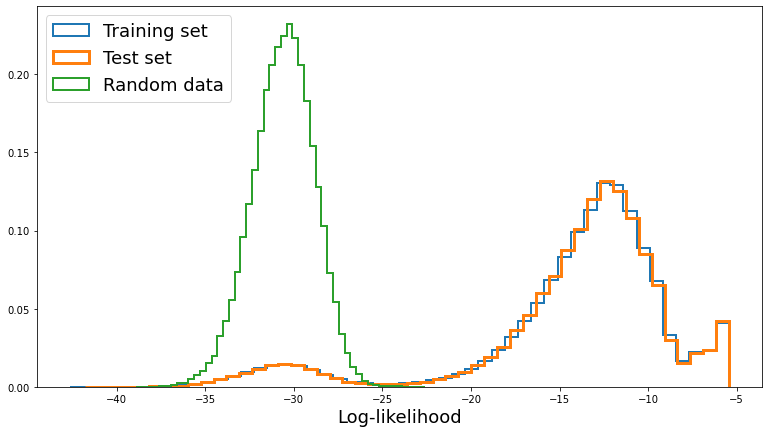

In [26]:
# check results on test set and on a set of random sequences
rand_data = np.random.randint(low=0, high=3, size=test_data.shape, dtype=np.int16)

fig = plt.figure(figsize=(13, 7), constrained_layout=False)
ax = fig.add_subplot()
ax.hist(RBM_SC.likelihood(train_data), bins=50, density=True, histtype='step', lw=2, fill=False, label="Training set")
ax.hist(RBM_SC.likelihood(test_data), bins=50, density=True, histtype='step', lw=3, fill=False, label="Test set")
ax.hist(RBM_SC.likelihood(rand_data), bins=50, density=True, histtype='step', lw=2, fill=False, label="Random data")

ax.legend(fontsize=18, loc=2)
ax.set_xlabel("Log-likelihood", fontsize=18)
;

In [27]:
# save RBM
out_path = '../RBM_retrained/'
if not os.path.isdir(out_path): # check if folder exists
    os.makedirs(out_path)
    
file_name = 'RBM_SC.data'
RBM_utils.saveRBM(out_path + file_name, RBM_SC)